# Importing libraries.

In [1]:
import numpy as np 
import pandas as pd
from scipy.stats import chi2_contingency
from sklearn.feature_selection import f_classif
from sklearn.model_selection import RandomizedSearchCV

# Importing DataSet

In [666]:
df = pd.read_csv('loan_data_2007_2014.csv')

In [667]:
df.info(verbose = True,null_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16545 entries, 0 to 16544
Data columns (total 145 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   id                                          0 non-null      float64
 1   member_id                                   0 non-null      float64
 2   loan_amnt                                   16545 non-null  int64  
 3   funded_amnt                                 16545 non-null  int64  
 4   funded_amnt_inv                             16545 non-null  int64  
 5   term                                        16545 non-null  object 
 6   int_rate                                    16545 non-null  float64
 7   installment                                 16545 non-null  float64
 8   grade                                       16545 non-null  object 
 9   sub_grade                                   16545 non-null  object 
 10  emp_title

In [668]:
pd.options.display.max_columns = None #Show all columns 
pd.options.display.max_rows = 100 #Show all rows 
columns = ['grade',
 'sub_grade',
 'home_ownership',
 'verification_status',
 'purpose',
 'loan_status',
 'recoveries',
 'collection_recovery_fee',
 'total_rec_prncp',
 'total_pymnt_inv',
 'total_pymnt',
 'int_rate',
 'last_pymnt_amnt',
 'out_prncp',
 'out_prncp_inv',
 'total_rec_late_fee',
 'last_credit_pull_d',
 'issue_d',
 'inq_last_6mths',
 'term',
 'revol_util',
 'annual_inc',
 'dti',
 'earliest_cr_line',
 'total_rec_int',
 'total_rev_hi_lim']

In [669]:
df['issue_d'].iloc[0:4271] = 'Dec-17'
df['issue_d'].iloc[4271:10000] = 'Dec-16'
df['issue_d'].iloc[10000:] = 'Dec-12'
lol1 = df.copy()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [670]:
dict = {}
for i in df['issue_d'].unique():
    dict[i] = [x for x in df.loc[df['issue_d'] == i].index]

# DATASET PREPROCESSING

In [671]:
list_to_drop1 = ['emp_title','desc','mths_since_last_major_derog','id','member_id','title','zip_code','url','last_pymnt_d',
                 'next_pymnt_d','pymnt_plan','application_type','policy_code','sub_grade']
df.drop(list_to_drop1,axis = 1,inplace = True) #Drop a list of features which we wrote before 
df_null = [x for x in df.columns if df[x].isnull().sum() > 2000] # Create a list of features with null values more then 2000
df.drop(df_null,axis = 1,inplace = True) #Drop them

In [672]:
df.loc[df['acc_now_delinq'] == 0, 'total_rev_hi_lim'] = 0 #Find a row where feature 'acc_now_delinq' = 0 and in this row change to 0 value of feature total_rev_hi_lim
df.loc[df['acc_now_delinq'] == 0, 'tot_cur_bal'] = 0 # Find a row where feature 'acc_now_delinq' = 0 and in this row change to 0 value of feature tot_cur_bal
df.loc[df['acc_now_delinq'] == 0, 'tot_coll_amt'] = 0 # Find a row where feature 'acc_now_delinq' = 0 and in this row change to 0 value of feature tot_coll_amt

In [673]:
df['term'] = pd.to_numeric(df['term'].str.replace('months','')) #From '10 months' create an integer value where we delete months and have only 10 with type int 

In [674]:
#Same idea as in previous code , here we replace an str with nothing 
df['emp_length'] = df['emp_length'].apply(lambda x:str(x).replace('+ years','').replace('< ','').replace(' ','').replace('year','').replace('s','')) #Same idea as in previous code , here we replace an str with nothing 
df.loc[df['emp_length'] == 'nan','emp_length'] = 0 #Described same thing as previous code 
df['emp_length'] = pd.to_numeric(df['emp_length']) #From str value to int value '40' ---> 40

In [675]:
#Creating a list of features with name median 
median = ['tot_cur_bal','tot_coll_amt','acc_now_delinq','collections_12_mths_ex_med'
         ,'total_acc','revol_util','pub_rec','annual_inc']
for i in median:
    df[i] = df.fillna(df[i].median())
#Filling all features wwhere we have null values with median 
df['earliest_cr_line'] = df['earliest_cr_line'].fillna(df['earliest_cr_line'].mode()[0])
#Filling all features where we have null values with moda 

In [676]:
df['issue_d'] = pd.to_datetime(df['issue_d'],format = '%b-%y') #Change type of feature (ex: Dec-16 --> 2016-12-01)
df['issue_d'] = round(pd.to_numeric((pd.to_datetime('2017-05-01') - df['issue_d'])/np.timedelta64(1,'M')))
#Here we are counting how many days are between 2 dates , then we converting it to months 
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'],format = '%b-%y') #Same idea as before 
df['earliest_cr_line'] = round(pd.to_numeric((pd.to_datetime('2017-05-01') - df['earliest_cr_line'])/np.timedelta64(1,'M')))

df['loan_status'] = np.where(df['loan_status'].isin(['Does not meet the credit policy. Status:Charged Off',
                                                     'Default','Charged Off','Late (31-120 days)']),1,0)
#In feature 'loan_status' we change all values which requires condition to 0 and thise which do not require with 1. 
df['last_credit_pull_d'].fillna(df['last_credit_pull_d'].mode()[0],inplace = True) #Filling NaN with moda 
df['mths_since_last_credit_pull_d'] = pd.to_datetime(df['last_credit_pull_d'],format = '%b-%y') #Same idea as before 
df['mths_since_last_credit_pull_d'] = round(pd.to_numeric((pd.to_datetime('2017-05-01') - df['mths_since_last_credit_pull_d'])/np.timedelta64(1,'M'))) #Same idea as before 
df.fillna(0,inplace = True) #All features where is null value fill with 0 

In [677]:
df.info(verbose = True,null_counts = True) #Info about dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16545 entries, 0 to 16544
Data columns (total 92 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   loan_amnt                      16545 non-null  int64  
 1   funded_amnt                    16545 non-null  int64  
 2   funded_amnt_inv                16545 non-null  int64  
 3   term                           16545 non-null  int64  
 4   int_rate                       16545 non-null  float64
 5   installment                    16545 non-null  float64
 6   grade                          16545 non-null  object 
 7   emp_length                     16545 non-null  int64  
 8   home_ownership                 16545 non-null  object 
 9   annual_inc                     16545 non-null  int64  
 10  verification_status            16545 non-null  object 
 11  issue_d                        16545 non-null  float64
 12  loan_status                    16545 non-null 

In [678]:
lol = df.copy()

# Creating WoE and IV function for discreate var.

In [679]:
def woe_discrete(df1,variable,target):
    df1 = pd.concat([df1[variable], df[target]], axis = 1) 
    df1 = pd.concat([df1.groupby(df1.columns.values[0])[df1.columns.values[1]].count(), #counting number of observations for each discrete variable
                     (1 - df1.groupby(df1.columns.values[0])[df1.columns.values[1]].mean())],axis =1) #counting proportions of good borowers to all amount
    df1.columns = ['n_obs','prop_good'] #Cahnge name of columns
    df1['prop_n_obs'] = df1['n_obs']/df1['n_obs'].sum() #Writing formulas 
    df1['n_good'] = df1['prop_good'] * df1['n_obs'] #Writing formulas 
    df1['n_bad'] = (1-df1['prop_good']) * df1['n_obs'] #Writing formulas 
    df1['prop_n_good'] = df1['n_good'] / df1['n_good'].sum() #Writing formulas 
    df1['prop_n_bad'] = df1['n_bad'] / df1['n_bad'].sum() #Writing formulas 
    df1['WoE'] = np.log(df1['prop_n_good']/df1['prop_n_bad']) #Writing formulas 
    df1 = df1.sort_values(['WoE']) #Sorting by WoE , from in increasing way 
    df1 = df1.reset_index(drop = False) #Drop index 
    df1['IV'] = (df1['prop_n_good'] - df1['prop_n_bad'])*df1['WoE'] #IV variable 
    df1['IV'] = df1['IV'].sum() #Sum of all categories for one main feature 
    return df1

In [680]:
df_temp = woe_discrete(df,
                      'verification_status','loan_status')
df_temp

,verification_status,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV
0,Verified,2331,0.996139,0.140888,2322.0,9.0,0.140531,0.409091,-1.068507,0.440212
1,Not Verified,8002,0.998875,0.483651,7993.0,9.0,0.483750,0.409091,0.167631,0.440212
2,Source Verified,6212,0.999356,0.375461,6208.0,4.0,0.375719,0.181818,0.725834,0.440212


In [681]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
def plot_woe(df,rotation = 0):
    x = np.array(df.iloc[:,0].apply(str)) #X axis variables
    y = df['WoE'] #Y axis variables 
    plt.figure(figsize=(18,6)) #Size of dashboard 
    plt.plot(x,y,marker = 'o',linestyle = '--',color = 'k') #Plotting 
    plt.xlabel(df.columns[0]) #Name of label X
    plt.ylabel('WoE') #Name of label Y
    plt.xticks(rotation = rotation) #Rotation of label X 

#  Creating WoE and IV function for continious var.

In [682]:
def woe_continious(df1,variable,target):
    df1 = pd.concat([df1[variable], df[target]], axis = 1)
    df1 = pd.concat([df1.groupby(df1.columns.values[0])[df1.columns.values[1]].count(),
                     (1 - df1.groupby(df1.columns.values[0])[df1.columns.values[1]].mean())],axis =1)
    df1.columns = ['n_obs','prop_good']
    df1['prop_n_obs'] = df1['n_obs']/df1['n_obs'].sum()
    df1['n_good'] = df1['prop_good'] * df1['n_obs']
    df1['n_bad'] = (1-df1['prop_good']) * df1['n_obs']
    df1['prop_n_good'] = df1['n_good'] / df1['n_good'].sum()
    df1['prop_n_bad'] = df1['n_bad'] / df1['n_bad'].sum()
    df1['WoE'] = np.log(df1['prop_n_good']/df1['prop_n_bad'])
    #df1 = df1.sort_values(['WoE'])
    df1 = df1.reset_index(drop = False)
    df1['IV'] = (df1['prop_n_good'] - df1['prop_n_bad'])*df1['WoE']
    df1['IV'] = df1['IV'].sum()
    return df1
#SAME IDEA AS I DESCRIBED BEFORE BUT FOR CONTINIOUS VARIABLES 

# Using chi2 for dicrete variables and ANOVA for continious variables 

In [683]:
chi2_check = {} #Creating dictionary 
X_train_cat = pd.DataFrame(data = df , columns = df.columns[df.dtypes == 'O']) #Create data frame only with Obj type features
for i in X_train_cat:
        chi, p, dof, ex = chi2_contingency(pd.crosstab(df['loan_status'], df[i]))
        chi2_check.setdefault('Feature',[]).append(i)
        chi2_check.setdefault('p-value',[]).append(round(p,10))
chi2_result = pd.DataFrame(data = chi2_check)
#Craeting data frame with every feature and each p-value
chi2_result.sort_values(by = ['p-value'], ascending = True, ignore_index = True, inplace = True) #Sorting features by p-value
chi2_result

,Feature,p-value
0,hardship_flag,0.000000
1,debt_settlement_flag,0.000000
2,grade,0.000002
3,verification_status,0.001059
4,purpose,0.053843
5,home_ownership,0.076786
6,last_credit_pull_d,0.127025
7,addr_state,0.329707
8,disbursement_method,0.466249
9,initial_list_status,0.608123


In [684]:
X_train_num = pd.DataFrame(data = df,columns = df.columns[df.dtypes != 'O']) #Create data frame only with non-Obj type features
X_train_num.fillna(X_train_num.mean(), inplace = True) #Filling null values 
F_statistic, p_values = f_classif(X_train_num, df['loan_status']) #Counting f-stats and p-value for ecah feature 
ANOVA_F_table = pd.DataFrame(data = {'Numerical_Feature': X_train_num.columns.values, 'F-Score': F_statistic, 'p values': p_values.round(decimals=10)})
#Creating dataframe with f-score and p-value 
ANOVA_F_table.sort_values(by = ['F-Score'], ascending = False, ignore_index = True, inplace = True) #Sorting features by p-value
ANOVA_F_table

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [ 9 26 27 43 69 70 76] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


,Numerical_Feature,F-Score,p values
0,loan_status,inf,0.000000e+00
1,total_rec_late_fee,79.501655,0.000000e+00
2,total_rec_int,25.668279,4.098000e-07
3,int_rate,19.239607,1.160090e-05
4,all_util,12.774319,3.524106e-04
5,mo_sin_old_il_acct,7.815168,5.186924e-03
6,inq_last_6mths,7.532329,6.066688e-03
7,percent_bc_gt_75,6.618622,1.010042e-02
8,bc_util,6.388326,1.149656e-02
9,mths_since_last_credit_pull_d,4.932390,2.637133e-02


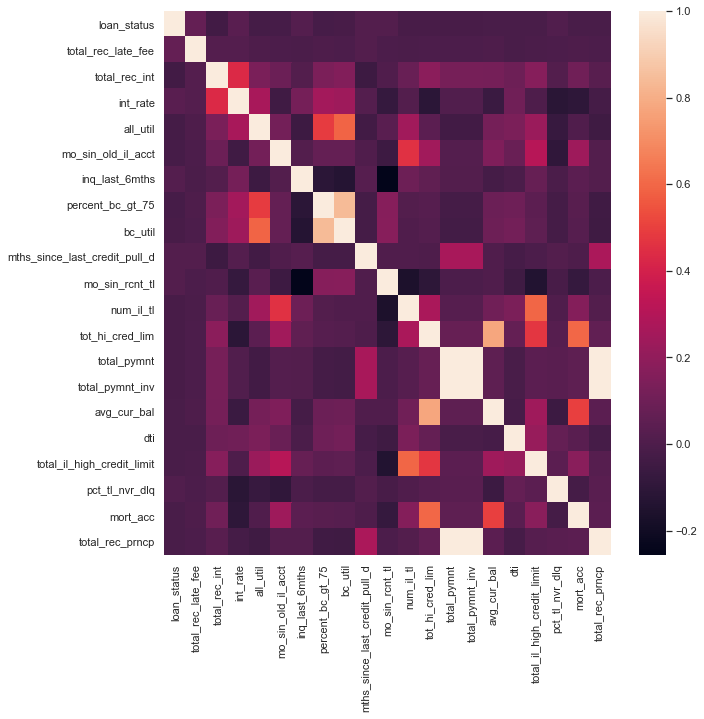

In [685]:
top_num =ANOVA_F_table.iloc[:21,0].to_list() #From Anova table take only best 20 features 
corr = X_train_num[top_num].corr() #Counting correlation betweeen every feature 
#corr.sort_values()
plt.figure(figsize=(10,10)) #Size of dashboard
sns.heatmap(corr); #Plot dashboard


# Creating final dataframe

In [686]:
df = pd.concat([df[chi2_result.iloc[:5,0].to_list()],df[ANOVA_F_table.iloc[:21,0].to_list()],df['total_rev_hi_lim']],axis = 1) 
#Concating best discrete and continious variables 

In [687]:
obj_df = pd.DataFrame(data = df , columns = df.columns[df.dtypes == 'O']) #Create a dataframe with obj type 
obj_df = pd.get_dummies(obj_df,prefix_sep = ':') #Get dummie variables from discrete features 
G = pd.concat([obj_df,df.iloc[:,5:26],lol['issue_d']],axis =1) #Concat main datafrae with discrete features 

# PD model creation

In [688]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split , RepeatedStratifiedKFold , cross_val_score , RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix , f1_score ,roc_auc_score ,classification_report , roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, auc


In [689]:
X = G.drop('loan_status',axis = 1)
y = df['loan_status']

In [690]:
X

,hardship_flag:0,hardship_flag:N,debt_settlement_flag:0,debt_settlement_flag:N,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,verification_status:Not Verified,verification_status:Source Verified,verification_status:Verified,purpose:car,purpose:credit_card,purpose:debt_consolidation,purpose:home_improvement,purpose:house,purpose:major_purchase,purpose:medical,purpose:moving,purpose:other,purpose:renewable_energy,purpose:small_business,purpose:vacation,total_rec_late_fee,total_rec_int,int_rate,all_util,mo_sin_old_il_acct,inq_last_6mths,percent_bc_gt_75,bc_util,mths_since_last_credit_pull_d,mo_sin_rcnt_tl,num_il_tl,tot_hi_cred_lim,total_pymnt,total_pymnt_inv,avg_cur_bal,dti,total_il_high_credit_limit,pct_tl_nvr_dlq,mort_acc,total_rec_prncp,issue_d
0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.0,53.04,13.56,28.0,140.0,1,0.0,5.9,-21.0,1.0,16.0,60124.0,167.02000,167.02,1878.0,18.24,18124.0,100.0,0.0,113.98,-7.0
1,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0.0,894.86,18.94,57.0,163.0,0,0.0,8.3,-21.0,3.0,27.0,372872.0,1507.11000,1507.11,24763.0,26.52,94072.0,95.0,3.0,612.25,-7.0
2,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0.0,141.10,17.97,35.0,87.0,0,0.0,0.0,-21.0,14.0,4.0,136927.0,353.89000,353.89,18383.0,10.51,10000.0,100.0,2.0,212.79,-7.0
3,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0.0,118.64,18.94,70.0,62.0,0,100.0,75.2,-21.0,5.0,7.0,385183.0,286.71000,286.71,30505.0,16.74,44984.0,100.0,3.0,168.07,-7.0
4,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.0,762.23,16.14,54.0,53.0,0,0.0,8.9,-21.0,2.0,9.0,157548.0,1423.21000,1423.21,9667.0,26.35,32332.0,92.3,2.0,660.98,-7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16540,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0.0,68.29,7.56,87.0,148.0,0,0.0,39.7,-21.0,3.0,29.0,132020.0,397.69000,397.69,15735.0,12.74,117020.0,100.0,0.0,329.40,53.0
16541,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,418.62,10.72,36.0,114.0,1,0.0,0.0,-21.0,7.0,5.0,59485.0,1369.78000,1369.78,2693.0,13.84,43885.0,100.0,0.0,951.16,53.0
16542,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0,477.69,15.02,65.0,142.0,0,50.0,76.8,-21.0,7.0,6.0,340371.0,1045.43000,1045.43,80166.0,9.50,33972.0,100.0,2.0,567.74,53.0
16543,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0.0,4.90,12.98,53.0,40.0,0,0.0,16.4,-21.0,14.0,2.0,32170.0,10004.90467,10004.90,3388.0,27.84,22570.0,100.0,0.0,10000.00,53.0


In [691]:

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 42) #Splitting data to train and test 80% to 20%
model = LogisticRegression(max_iter=975, class_weight = 'balanced',penalty = 'l2',solver = 'lbfgs',C = 1000).fit(X_train,y_train)
#Creating LogisticRegression model , plugging main paramethers to increase roc_auc 
cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=1, random_state=1) #Splitting our samples into balances samples 
scores = cross_val_score(model,X_train, y_train, scoring = 'roc_auc', cv = cv) #Training model 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [692]:
AUROC = np.mean(scores) #ROC_AUC
GINI = AUROC * 2 - 1 #GINNI 

In [693]:
AUROC , GINI

(0.9869958474134598, 0.9739916948269196)

In [694]:
y_pred = model.predict(X_test)
roc_auc_score(y_test,y_pred)

0.9959152798789713

In [695]:
lol1['issue_d']

0        Dec-17
1        Dec-17
2        Dec-17
3        Dec-17
4        Dec-17
          ...  
16540    Dec-12
16541    Dec-12
16542    Dec-12
16543    Dec-12
16544    Dec-12
Name: issue_d, Length: 16545, dtype: object

In [696]:
X_train = G.drop('loan_status',axis = 1)
y_train = G['loan_status']
def ginni(df,z,lol1):
    scores = []
    for i in lol1[z].unique(): 
        dict[i] = [x for x in df.loc[df['issue_d'] == i].index]
        df = pd.DataFrame(data = df , index = dict[i][0:])
        y_pred = model.predict(X_train)
        roc_auc = roc_auc_score(y_train,y_pred)
        
        print(f'For {i} month we have roc_auc_score {roc_auc}')
    return 
     
        
       
ginni(G,'issue_d',lol1)

For Dec-17 month we have roc_auc_score 0.9953095684803002
For Dec-16 month we have roc_auc_score 0.9953095684803002
For Dec-12 month we have roc_auc_score 0.9953095684803002


In [589]:
for i in G['issue_d'].unique(): 
        dict[i] = [x for x in G.loc[G['issue_d'] == 'Dec-19'].index]
        l = pd.DataFrame(data = G , index = dict[i][0:])
        print(i)
        
        y_pred = model.predict(X_train)
        roc_auc = roc_auc_score(y_train,y_pred)
        print(roc_auc)

-7.0
0.9435113733797347
5.0
0.9435113733797347
53.0
0.9435113733797347


In [513]:
G['issue_d']

Series([], Name: issue_d, dtype: float64)

In [29]:
grid = {
    'penalty':['l1', 'l2', 'elasticnet', 'none'],
    'solver' :['newton-cg','lbfgs','liblinear','sag','saga'],
    'multi_class': ['auto','ovr','multinomial'],
    'max_iter' : [x for x in np.linspace(100,1500,23)],
    'C' : [x for x in np.linspace(1,1000,9)]
}

In [31]:
clf = RandomizedSearchCV(model,param_distributions=grid, random_state=0,n_iter = 2, scoring = 'roc_auc')
search = clf.fit(X_train,y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logist

In [33]:
search.best_params_

{'solver': 'saga',
 'penalty': 'none',
 'multi_class': 'multinomial',
 'max_iter': 1245.4545454545455,
 'C': 875.125}

# CREATING SCORECARD

In [105]:
summary_table = pd.DataFrame(columns = ['Feature name'], data = X_train.columns.values)
summary_table['Coefficients'] = model.coef_.reshape(46,1)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', model.intercept_[0]]
summary_table.sort_index(inplace = True)

In [106]:
summary_table

,Feature name,Coefficients
0,Intercept,-0.000963
1,hardship_flag:0,0.000000
2,hardship_flag:N,-0.000963
3,debt_settlement_flag:0,0.000000
4,debt_settlement_flag:N,-0.000963
5,grade:A,0.007715
6,grade:B,-0.013008
7,grade:C,-0.000832
8,grade:D,0.005335
9,grade:E,-0.000579


In [107]:
y_hat_test = model.predict(X_test)
y_hat_test_proba = model.predict_proba(X_test) 
y_hat_test_proba = y_hat_test_proba[: , 1]

In [108]:
y_test_temp = y_test.copy()
y_test_temp.reset_index(drop = True, inplace = True)
y_test_proba = pd.concat([y_test_temp, pd.DataFrame(y_hat_test_proba)], axis = 1)

In [109]:
y_test_proba

,loan_status,0
0,1,1.000000
1,1,0.928148
2,1,0.999985
3,1,1.000000
4,1,1.000000
...,...,...
3304,1,0.980597
3305,1,1.000000
3306,1,1.000000
3307,1,1.000000


In [110]:
y_test_proba.columns = ['y_test_class_actual', 'y_hat_test_proba']
y_test_proba.index = X_test.index
y_test_proba

,y_test_class_actual,y_hat_test_proba
8977,1,1.000000
8822,1,0.928148
7753,1,0.999985
16428,1,1.000000
3706,1,1.000000
...,...,...
5215,1,0.980597
4288,1,1.000000
7666,1,1.000000
5327,1,1.000000


In [111]:
tr = 0.5
y_test_proba['y_test_class_predicted'] = np.where(y_test_proba['y_hat_test_proba'] > tr, 1, 0)
confusion_matrix(y_test_proba['y_test_class_actual'], y_test_proba['y_test_class_predicted'], normalize = 'all')

array([[0.00120882, 0.        ],
       [0.01178604, 0.98700514]])

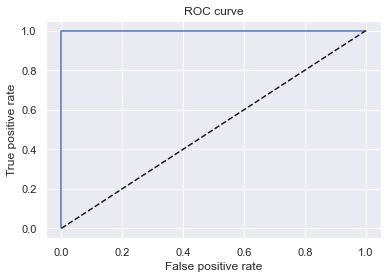

In [112]:
fpr, tpr, thresholds = roc_curve(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])
# plot the ROC curve
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');

In [114]:
AUROC = roc_auc_score(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])
GINI = AUROC*2 - 1
AUROC , GINI

(0.9996217851739788, 0.9992435703479576)

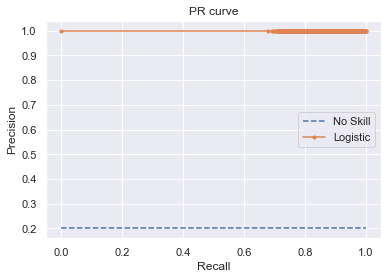

In [115]:
no_skill = len(y_test[y_test == 1]) / len(y)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
precision, recall, thresholds = precision_recall_curve(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])
plt.plot(recall, precision, marker='.', label='Logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('PR curve');

In [116]:
auc_pr = auc(recall, precision)
auc_pr

0.9999995424866267

In [117]:
df_scorecard = summary_table.copy()
df_scorecard['Original feature name'] = df_scorecard['Feature name'].str.split(':').str[0]

In [118]:
min_score = 1
max_score = 751

min_sum_coef = df_scorecard.groupby('Original feature name')['Coefficients'].min().sum()
max_sum_coef = df_scorecard.groupby('Original feature name')['Coefficients'].max().sum()
df_scorecard['Score - Calculation'] = df_scorecard['Coefficients'] * (max_score - min_score) / (max_sum_coef - min_sum_coef)
df_scorecard.loc[0, 'Score - Calculation'] = ((df_scorecard.loc[0,'Coefficients'] - min_sum_coef) / (max_sum_coef - min_sum_coef)) * (max_score - min_score) + min_score
df_scorecard['Score - Preliminary'] = df_scorecard['Score - Calculation'].round()
df_scorecard

,Feature name,Coefficients,Original feature name,Score - Calculation,Score - Preliminary
0,Intercept,-0.000963,Intercept,-2511.335623,-2511.0
1,hardship_flag:0,0.000000,hardship_flag,0.000000,0.0
2,hardship_flag:N,-0.000963,hardship_flag,-10.771399,-11.0
3,debt_settlement_flag:0,0.000000,debt_settlement_flag,0.000000,0.0
4,debt_settlement_flag:N,-0.000963,debt_settlement_flag,-10.771399,-11.0
5,grade:A,0.007715,grade,86.303405,86.0
6,grade:B,-0.013008,grade,-145.522912,-146.0
7,grade:C,-0.000832,grade,-9.312221,-9.0
8,grade:D,0.005335,grade,59.678805,60.0
9,grade:E,-0.000579,grade,-6.478238,-6.0


In [119]:
df_scorecard.loc[0, 'Score - Calculation']

-2511.3356232944234

In [120]:
min_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Preliminary'].min().sum()
max_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Preliminary'].max().sum()
print(min_sum_score_prel)
print(max_sum_score_prel)

4.0
754.0


In [121]:
score_card = df_scorecard.iloc[:,[0,4]]

In [122]:
score_card

,Feature name,Score - Preliminary
0,Intercept,-2511.0
1,hardship_flag:0,0.0
2,hardship_flag:N,-11.0
3,debt_settlement_flag:0,0.0
4,debt_settlement_flag:N,-11.0
5,grade:A,86.0
6,grade:B,-146.0
7,grade:C,-9.0
8,grade:D,60.0
9,grade:E,-6.0


In [123]:
X_test.insert(0, 'Intercept', 1)
y_scores = X_test.dot(score_card['Score - Preliminary'].values)

In [124]:
y_scores

8977      535428.38
8822       43938.97
7753      124704.04
16428     235500.93
3706      429755.37
            ...    
5215      398730.20
4288      899649.21
7666      490884.24
5327      715483.90
9252     3138491.38
Length: 3309, dtype: float64

# HHI TEST (Herhindahl

In [125]:
df_cutoffs = pd.concat([pd.DataFrame(thresholds), pd.DataFrame(fpr), pd.DataFrame(tpr)], axis = 1)
df_cutoffs.columns = ['thresholds', 'fpr', 'tpr']

In [126]:
df_cutoffs.head()

,thresholds,fpr,tpr
0,1.504467e-07,0.0,0.000000
1,5.253036e-07,0.0,0.679576
2,2.216016e-06,0.0,0.691679
3,5.525052e-06,0.0,0.696520
4,1.364275e-05,0.0,0.699244


In [127]:
df_cutoffs['thresholds'][0] = 1 - 1 / np.power(10, 16)

In [128]:
df_cutoffs['Score'] = ((np.log(df_cutoffs['thresholds'] / (1 - df_cutoffs['thresholds'])) - min_sum_coef) * ((max_score - min_score) / (max_sum_coef - min_sum_coef)) + min_score).round()

In [129]:
df_cutoffs['Score'][0] = max_score

In [130]:
def n_approved(p):
    return np.where(y_test_proba['y_hat_test_proba'] >= p, 1, 0).sum()

In [131]:
df_cutoffs['N Approved'] = df_cutoffs['thresholds'].apply(n_approved)
df_cutoffs['N Rejected'] = y_test_proba['y_hat_test_proba'].shape[0] - df_cutoffs['N Approved']
df_cutoffs['Approval Rate'] = df_cutoffs['N Approved'] / y_test_proba['y_hat_test_proba'].shape[0]
df_cutoffs['Rejection Rate'] = 1 - df_cutoffs['Approval Rate']

In [132]:
df_cutoffs

,thresholds,fpr,tpr,Score,N Approved,N Rejected,Approval Rate,Rejection Rate
0,1.000000e+00,0.0,0.000000,751.0,2804,505,0.847386,0.152614
1,5.253036e-07,0.0,0.679576,-164254.0,3307,2,0.999396,0.000604
2,2.216016e-06,0.0,0.691679,-148151.0,3306,3,0.999093,0.000907
3,5.525052e-06,0.0,0.696520,-137931.0,3305,4,0.998791,0.001209
4,1.364275e-05,0.0,0.699244,-127819.0,3304,5,0.998489,0.001511
...,...,...,...,...,...,...,...,...
927,1.000000e+00,NaN,NaN,385205.0,2328,981,0.703536,0.296464
928,1.000000e+00,NaN,NaN,388423.0,2311,998,0.698398,0.301602
929,1.000000e+00,NaN,NaN,392959.0,2302,1007,0.695678,0.304322
930,1.000000e+00,NaN,NaN,400713.0,2286,1023,0.690843,0.309157


In [133]:
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold: %f' % (best_thresh))

Best Threshold: 0.641754


In [136]:
df_cutoffs.loc[df_cutoffs['thresholds'].between(0.641754,0.642)]

,thresholds,fpr,tpr,Score,N Approved,N Rejected,Approval Rate,Rejection Rate
45,0.641754,0.0,0.999395,4021.0,3263,46,0.986099,0.013901


In [ ]:
###CUT OF IS 490

#df_scorecard.to_csv('df_scorecard.csv')

In [137]:
df_cutoffs

,thresholds,fpr,tpr,Score,N Approved,N Rejected,Approval Rate,Rejection Rate
0,1.000000e+00,0.0,0.000000,751.0,2804,505,0.847386,0.152614
1,5.253036e-07,0.0,0.679576,-164254.0,3307,2,0.999396,0.000604
2,2.216016e-06,0.0,0.691679,-148151.0,3306,3,0.999093,0.000907
3,5.525052e-06,0.0,0.696520,-137931.0,3305,4,0.998791,0.001209
4,1.364275e-05,0.0,0.699244,-127819.0,3304,5,0.998489,0.001511
...,...,...,...,...,...,...,...,...
927,1.000000e+00,NaN,NaN,385205.0,2328,981,0.703536,0.296464
928,1.000000e+00,NaN,NaN,388423.0,2311,998,0.698398,0.301602
929,1.000000e+00,NaN,NaN,392959.0,2302,1007,0.695678,0.304322
930,1.000000e+00,NaN,NaN,400713.0,2286,1023,0.690843,0.309157
